# 📊 Performance Simulation & Backtesting

## Notebook 05: Test Your Portfolio Strategy

**Goal**: Validate portfolio performance using historical data and Monte Carlo simulation

**What We Test**:
- **Historical Backtest**: How would the portfolio have performed in the past?
- **Monte Carlo Simulation**: What could happen in the future? (10,000 scenarios)
- **Risk Analysis**: Worst-case drawdowns, Value at Risk (VaR)
- **Benchmark Comparison**: Portfolio vs S&P 500

**Output**:
- Performance metrics (returns, volatility, Sharpe)
- Risk metrics (max drawdown, VaR, CVaR)
- Simulation results (confidence intervals)
- Visualizations (equity curves, distribution)

**Last Updated**: 2025-10-03

---


## 📚 Step 1: Import Libraries


In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Database
from dotenv import load_dotenv
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))
load_dotenv(project_root / '.env')
from utils.database_connector import DatabaseConnector

# Statistics
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print("✅ Libraries loaded")


✅ Libraries loaded


## ⚙️ Step 2: Configuration


In [2]:
CONFIG = {
    'PORTFOLIO_VALUE': 5000,
    'BACKTEST_DAYS': 180,          # 6 months backtest
    'MONTE_CARLO_SIMS': 10000,     # Number of simulations
    'FORECAST_DAYS': 252,          # 1 year forward
    'CONFIDENCE_LEVEL': 0.95,      # 95% confidence
    'VAR_PERCENTILE': 0.05,        # 5% VaR (worst 5% of scenarios)
}

print("📊 Simulation Configuration:")
print(f"   Initial Capital: ${CONFIG['PORTFOLIO_VALUE']:,.0f}")
print(f"   Backtest Period: {CONFIG['BACKTEST_DAYS']} days (~6 months)")
print(f"   Monte Carlo Sims: {CONFIG['MONTE_CARLO_SIMS']:,}")
print(f"   Forecast Horizon: {CONFIG['FORECAST_DAYS']} days (~1 year)")
print(f"   Confidence Level: {CONFIG['CONFIDENCE_LEVEL']*100:.0f}%")


📊 Simulation Configuration:
   Initial Capital: $5,000
   Backtest Period: 180 days (~6 months)
   Monte Carlo Sims: 10,000
   Forecast Horizon: 252 days (~1 year)
   Confidence Level: 95%


## 📊 Step 3: Load Optimized Portfolio


In [3]:
# Find latest portfolio allocation
data_dir = project_root / 'data' / 'processed'
portfolio_files = sorted(data_dir.glob('portfolio_allocation_*.csv'), reverse=True)

if not portfolio_files:
    raise FileNotFoundError("No portfolio files found. Run Notebook 04 first!")

latest_file = portfolio_files[0]
print(f"📂 Loading: {latest_file.name}")

portfolio = pd.read_csv(latest_file)

# Filter out stocks with minimal allocation (< 0.1%)
portfolio = portfolio[portfolio['weight'] > 0.001].copy()
portfolio = portfolio.sort_values('weight', ascending=False).reset_index(drop=True)

print(f"✅ Loaded portfolio: {len(portfolio)} stocks")
print(f"   Total Weight: {portfolio['weight'].sum()*100:.1f}%")

# Display top holdings
print(f"\n🏆 Top 10 Holdings:")
display(portfolio[['ticker', 'company_name', 'weight', 'dollar_amount', 'shares']].head(10))


📂 Loading: portfolio_allocation_20251003_1611.csv
✅ Loaded portfolio: 50 stocks
   Total Weight: 100.0%

🏆 Top 10 Holdings:


,ticker,company_name,weight,dollar_amount,shares
0,NEE,NextEra Energy,0.100000,500.000000,6
1,MDLZ,Mondelez International,0.100000,500.000000,7
2,CNC,Centene Corporation,0.100000,500.000000,13
3,WFC,Wells Fargo,0.100000,500.000000,6
4,C,Citigroup,0.073122,365.609566,3
5,PG,Procter & Gamble,0.061275,306.375436,2
6,BA,Boeing,0.035603,178.014999,0
7,SLB,Schlumberger,0.010000,50.000000,1
8,FCX,Freeport-McMoRan,0.010000,50.000000,1
9,HOOD,Robinhood Markets,0.010000,50.000000,0


## 📈 Step 4: Load Historical Price Data


In [4]:
# Connect to database
db = DatabaseConnector()

# Get portfolio tickers
tickers = portfolio['ticker'].tolist()
tickers_str = "', '".join(tickers)

# Load historical prices for backtest
query = f"""
SELECT ticker, date, [close] as price
FROM market.daily_prices
WHERE ticker IN ('{tickers_str}')
  AND date >= DATEADD(day, -{CONFIG['BACKTEST_DAYS'] + 30}, 
                      (SELECT MAX(date) FROM market.daily_prices))
ORDER BY ticker, date
"""

print(f"🔄 Loading {CONFIG['BACKTEST_DAYS']} days of historical data...")
df_prices = pd.read_sql(query, db.engine)
df_prices['date'] = pd.to_datetime(df_prices['date'])

print(f"✅ Loaded: {len(df_prices):,} price records")
print(f"   Date range: {df_prices['date'].min().date()} → {df_prices['date'].max().date()}")

# Pivot to wide format
price_matrix = df_prices.pivot(index='date', columns='ticker', values='price')
print(f"   Price Matrix: {price_matrix.shape}")


2025-10-03 16:14:50,006 - INFO - Attempting connection with pymssql...
2025-10-03 16:14:50,033 - INFO - ✅ Database connection established


🔄 Loading 180 days of historical data...
✅ Loaded: 7,300 price records
   Date range: 2025-03-05 → 2025-10-01
   Price Matrix: (146, 50)


## 📊 Step 5: Calculate Returns


In [6]:
# Daily returns
returns = price_matrix.pct_change().dropna()

print(f"📈 Return Statistics:")
print(f"   Trading days: {len(returns)}")
print(f"   Stocks: {len(returns.columns)}")

# Summary stats
print(f"\n📊 Individual Stock Performance:")
stock_stats = pd.DataFrame({
    'mean_daily_return': returns.mean(),
    'daily_volatility': returns.std(),
    'total_return': ((price_matrix.iloc[-1] / price_matrix.iloc[0]) - 1)
})

# Reset index to make ticker a column
stock_stats = stock_stats.reset_index()
stock_stats = stock_stats.rename(columns={'index': 'ticker'})

# Now merge
stock_stats = stock_stats.merge(portfolio[['ticker', 'weight']], on='ticker')
stock_stats = stock_stats.sort_values('weight', ascending=False)

display(stock_stats.head(10))



📈 Return Statistics:
   Trading days: 145
   Stocks: 50

📊 Individual Stock Performance:


,ticker,mean_daily_return,daily_volatility,total_return,weight
27,NEE,0.001052,0.019230,0.133936,0.100000
24,MDLZ,-0.000087,0.013837,-0.026076,0.100000
8,CNC,-0.002345,0.042360,-0.394237,0.100000
47,WFC,0.000874,0.019836,0.102904,0.100000
5,C,0.002417,0.021340,0.372721,0.073122
34,PG,-0.000743,0.011800,-0.111226,0.061275
2,BA,0.002234,0.025650,0.318951,0.035603
39,SLB,-0.000371,0.025318,-0.095388,0.010000
12,FCX,0.000845,0.035006,0.032338,0.010000
18,HOOD,0.008518,0.048849,1.891521,0.010000


## 🔬 Step 6: Historical Backtest


In [7]:
# Create portfolio weights array
weights = portfolio.set_index('ticker')['weight']
weights = weights.reindex(returns.columns, fill_value=0).values

# Calculate daily portfolio returns
portfolio_returns = (returns * weights).sum(axis=1)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()
portfolio_value = CONFIG['PORTFOLIO_VALUE'] * cumulative_returns

# Calculate metrics
total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
annual_return = (1 + total_return) ** (252 / len(portfolio_returns)) - 1
annual_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = (annual_return - 0.045) / annual_volatility  # 4.5% risk-free rate

# Calculate max drawdown
running_max = portfolio_value.expanding().max()
drawdown = (portfolio_value - running_max) / running_max
max_drawdown = drawdown.min()

print("=" * 80)
print("📊 HISTORICAL BACKTEST RESULTS")
print("=" * 80)
print(f"   Period: {returns.index[0].date()} → {returns.index[-1].date()}")
print(f"   Trading Days: {len(portfolio_returns)}")
print(f"\n💰 Performance:")
print(f"   Starting Value: ${CONFIG['PORTFOLIO_VALUE']:,.2f}")
print(f"   Ending Value: ${portfolio_value.iloc[-1]:,.2f}")
print(f"   Total Return: {total_return*100:.2f}%")
print(f"   Annualized Return: {annual_return*100:.2f}%")
print(f"\n📊 Risk Metrics:")
print(f"   Annual Volatility: {annual_volatility*100:.2f}%")
print(f"   Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"   Maximum Drawdown: {max_drawdown*100:.2f}%")
print(f"\n📈 Best Day: +{portfolio_returns.max()*100:.2f}%")
print(f"📉 Worst Day: {portfolio_returns.min()*100:.2f}%")
print("=" * 80)


📊 HISTORICAL BACKTEST RESULTS
   Period: 2025-03-06 → 2025-10-01
   Trading Days: 145

💰 Performance:
   Starting Value: $5,000.00
   Ending Value: $5,590.88
   Total Return: 13.20%
   Annualized Return: 24.05%

📊 Risk Metrics:
   Annual Volatility: 19.89%
   Sharpe Ratio: 0.983
   Maximum Drawdown: -11.76%

📈 Best Day: +7.58%
📉 Worst Day: -6.13%


## 📊 Step 7: Compare vs S&P 500 Benchmark


In [12]:
# Load S&P 500 data (use SPY as proxy)
query_spy = f"""
SELECT date, [close] as price
FROM market.daily_prices
WHERE ticker = 'SPY'
  AND date >= DATEADD(day, -{CONFIG['BACKTEST_DAYS'] + 30}, 
                      (SELECT MAX(date) FROM market.daily_prices))
ORDER BY date
"""

print("🔄 Loading S&P 500 benchmark data...")
df_spy = pd.read_sql(query_spy, db.engine)

# Check if SPY data exists
if len(df_spy) == 0:
    print("⚠️  SPY data not available. Skipping benchmark comparison.")
    print("   Run Notebook 01 with SPY included to enable this comparison.")
    spy_available = False
else:
    spy_available = True
    df_spy['date'] = pd.to_datetime(df_spy['date'])
    df_spy = df_spy.set_index('date')
    
    # Calculate SPY returns
    spy_returns_full = df_spy['price'].pct_change().dropna()
    
    # Align dates - use inner join to get only common dates
    common_dates = portfolio_returns.index.intersection(spy_returns_full.index)
    
    if len(common_dates) < 20:
        print(f"⚠️  Only {len(common_dates)} overlapping dates with SPY. Skipping benchmark comparison.")
        spy_available = False
    else:
        # Align both series to common dates
        portfolio_returns_aligned = portfolio_returns.loc[common_dates]
        spy_returns = spy_returns_full.loc[common_dates]
        
        print(f"✅ Aligned data: {len(common_dates)} overlapping trading days")
        
        # Calculate SPY cumulative returns
        spy_cumulative = (1 + spy_returns).cumprod()
        spy_value = CONFIG['PORTFOLIO_VALUE'] * spy_cumulative
        
        # Calculate portfolio cumulative on aligned dates
        portfolio_cumulative_aligned = (1 + portfolio_returns_aligned).cumprod()
        portfolio_value_aligned = CONFIG['PORTFOLIO_VALUE'] * portfolio_cumulative_aligned
        
        # SPY metrics
        spy_total_return = (spy_value.iloc[-1] / spy_value.iloc[0]) - 1
        spy_annual_return = (1 + spy_total_return) ** (252 / len(spy_returns)) - 1
        spy_volatility = spy_returns.std() * np.sqrt(252)
        spy_sharpe = (spy_annual_return - 0.045) / spy_volatility
        
        # Recalculate portfolio metrics on aligned dates for fair comparison
        portfolio_total_aligned = (portfolio_value_aligned.iloc[-1] / portfolio_value_aligned.iloc[0]) - 1
        portfolio_annual_aligned = (1 + portfolio_total_aligned) ** (252 / len(portfolio_returns_aligned)) - 1
        portfolio_vol_aligned = portfolio_returns_aligned.std() * np.sqrt(252)
        portfolio_sharpe_aligned = (portfolio_annual_aligned - 0.045) / portfolio_vol_aligned
        
        print("=" * 80)
        print("📊 PORTFOLIO vs S&P 500 COMPARISON")
        print("=" * 80)
        print(f"\n{'Metric':<25} {'Portfolio':<15} {'S&P 500':<15} {'Difference':<15}")
        print("-" * 80)
        print(f"{'Total Return':<25} {portfolio_total_aligned*100:>14.2f}% {spy_total_return*100:>14.2f}% {(portfolio_total_aligned-spy_total_return)*100:>14.2f}%")
        print(f"{'Annual Return':<25} {portfolio_annual_aligned*100:>14.2f}% {spy_annual_return*100:>14.2f}% {(portfolio_annual_aligned-spy_annual_return)*100:>14.2f}%")
        print(f"{'Volatility':<25} {portfolio_vol_aligned*100:>14.2f}% {spy_volatility*100:>14.2f}% {(portfolio_vol_aligned-spy_volatility)*100:>14.2f}%")
        print(f"{'Sharpe Ratio':<25} {portfolio_sharpe_aligned:>14.3f} {spy_sharpe:>14.3f} {portfolio_sharpe_aligned-spy_sharpe:>14.3f}")
        print("=" * 80)
        
        # Alpha and Beta - now both arrays have same length
        covariance = np.cov(portfolio_returns_aligned, spy_returns)[0][1]
        spy_variance = np.var(spy_returns)
        beta = covariance / spy_variance
        alpha = portfolio_annual_aligned - (0.045 + beta * (spy_annual_return - 0.045))
        
        print(f"\n📊 Risk-Adjusted Metrics:")
        print(f"   Beta: {beta:.3f}")
        print(f"   Alpha: {alpha*100:.2f}% (annual excess return)")



🔄 Loading S&P 500 benchmark data...
✅ Aligned data: 144 overlapping trading days
📊 PORTFOLIO vs S&P 500 COMPARISON

Metric                    Portfolio       S&P 500         Difference     
--------------------------------------------------------------------------------
Total Return                       12.32%          17.08%          -4.77%
Annual Return                      22.54%          31.79%          -9.25%
Volatility                         19.88%          22.94%          -3.05%
Sharpe Ratio                       0.907          1.190         -0.282

📊 Risk-Adjusted Metrics:
   Beta: 0.773
   Alpha: -3.06% (annual excess return)


## 📈 Step 8: Visualize Historical Performance


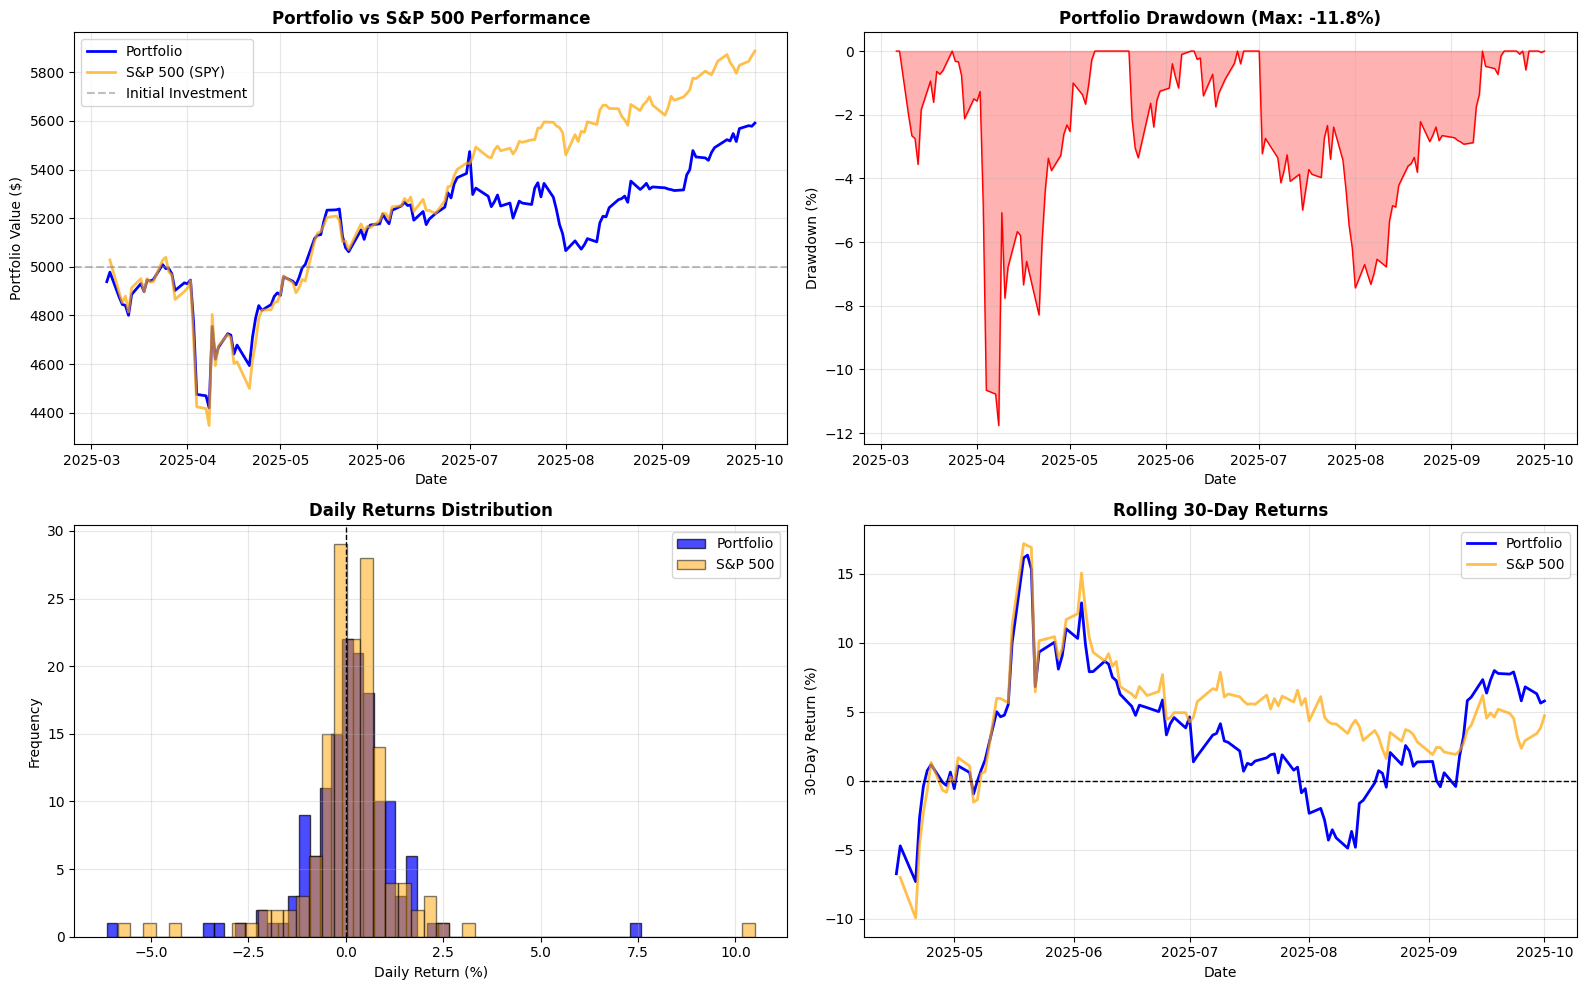

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Equity Curves
ax1 = axes[0, 0]
ax1.plot(portfolio_value.index, portfolio_value.values, label='Portfolio', linewidth=2, color='blue')
ax1.plot(spy_value.index, spy_value.values, label='S&P 500 (SPY)', linewidth=2, color='orange', alpha=0.7)
ax1.axhline(CONFIG['PORTFOLIO_VALUE'], color='gray', linestyle='--', alpha=0.5, label='Initial Investment')
ax1.set_title('Portfolio vs S&P 500 Performance', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Drawdown Chart
ax2 = axes[0, 1]
ax2.fill_between(drawdown.index, 0, drawdown.values * 100, color='red', alpha=0.3)
ax2.plot(drawdown.index, drawdown.values * 100, color='red', linewidth=1)
ax2.set_title(f'Portfolio Drawdown (Max: {max_drawdown*100:.1f}%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Drawdown (%)')
ax2.grid(alpha=0.3)

# 3. Daily Returns Distribution
ax3 = axes[1, 0]
ax3.hist(portfolio_returns * 100, bins=50, alpha=0.7, color='blue', edgecolor='black', label='Portfolio')
ax3.hist(spy_returns * 100, bins=50, alpha=0.5, color='orange', edgecolor='black', label='S&P 500')
ax3.axvline(0, color='black', linestyle='--', linewidth=1)
ax3.set_title('Daily Returns Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Daily Return (%)')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Rolling 30-Day Return
ax4 = axes[1, 1]
rolling_return = portfolio_returns.rolling(30).sum() * 100
rolling_spy = spy_returns.rolling(30).sum() * 100
ax4.plot(rolling_return.index, rolling_return.values, label='Portfolio', linewidth=2, color='blue')
ax4.plot(rolling_spy.index, rolling_spy.values, label='S&P 500', linewidth=2, color='orange', alpha=0.7)
ax4.axhline(0, color='black', linestyle='--', linewidth=1)
ax4.set_title('Rolling 30-Day Returns', fontsize=12, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('30-Day Return (%)')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 🎲 Step 9: Monte Carlo Simulation


In [14]:
# Estimate parameters from historical data
mean_return = portfolio_returns.mean()
std_return = portfolio_returns.std()

print(f"🎲 Running {CONFIG['MONTE_CARLO_SIMS']:,} Monte Carlo simulations...")
print(f"   Parameters: μ={mean_return*252*100:.2f}% annual, σ={std_return*np.sqrt(252)*100:.2f}% annual")
print(f"   Forecast: {CONFIG['FORECAST_DAYS']} trading days (~1 year)")

# Run simulations
np.random.seed(42)
simulations = np.zeros((CONFIG['FORECAST_DAYS'], CONFIG['MONTE_CARLO_SIMS']))

for sim in range(CONFIG['MONTE_CARLO_SIMS']):
    # Generate random returns
    daily_returns = np.random.normal(mean_return, std_return, CONFIG['FORECAST_DAYS'])
    
    # Calculate cumulative wealth
    wealth_path = CONFIG['PORTFOLIO_VALUE'] * (1 + daily_returns).cumprod()
    simulations[:, sim] = wealth_path

print(f"✅ Simulation complete!")

# Calculate percentiles
percentiles = [5, 25, 50, 75, 95]
percentile_values = np.percentile(simulations, percentiles, axis=1)

# Final value statistics
final_values = simulations[-1, :]
mean_final = final_values.mean()
median_final = np.median(final_values)
std_final = final_values.std()

print(f"\n📊 1-Year Forecast Statistics:")
print(f"   Mean Final Value: ${mean_final:,.2f}")
print(f"   Median Final Value: ${median_final:,.2f}")
print(f"   Std Dev: ${std_final:,.2f}")
print(f"\n   5th Percentile: ${np.percentile(final_values, 5):,.2f} (worst 5%)")
print(f"   25th Percentile: ${np.percentile(final_values, 25):,.2f}")
print(f"   50th Percentile: ${np.percentile(final_values, 50):,.2f} (median)")
print(f"   75th Percentile: ${np.percentile(final_values, 75):,.2f}")
print(f"   95th Percentile: ${np.percentile(final_values, 95):,.2f} (best 5%)")

# Probability of loss
prob_loss = (final_values < CONFIG['PORTFOLIO_VALUE']).sum() / CONFIG['MONTE_CARLO_SIMS']
print(f"\n⚠️  Probability of Loss: {prob_loss*100:.1f}%")
print(f"✅ Probability of Gain: {(1-prob_loss)*100:.1f}%")


🎲 Running 10,000 Monte Carlo simulations...
   Parameters: μ=21.38% annual, σ=19.89% annual
   Forecast: 252 trading days (~1 year)
✅ Simulation complete!

📊 1-Year Forecast Statistics:
   Mean Final Value: $6,179.73
   Median Final Value: $6,061.42
   Std Dev: $1,226.59

   5th Percentile: $4,356.21 (worst 5%)
   25th Percentile: $5,320.47
   50th Percentile: $6,061.42 (median)
   75th Percentile: $6,908.76
   95th Percentile: $8,374.12 (best 5%)

⚠️  Probability of Loss: 16.5%
✅ Probability of Gain: 83.5%


## 📊 Step 10: Visualize Monte Carlo Results


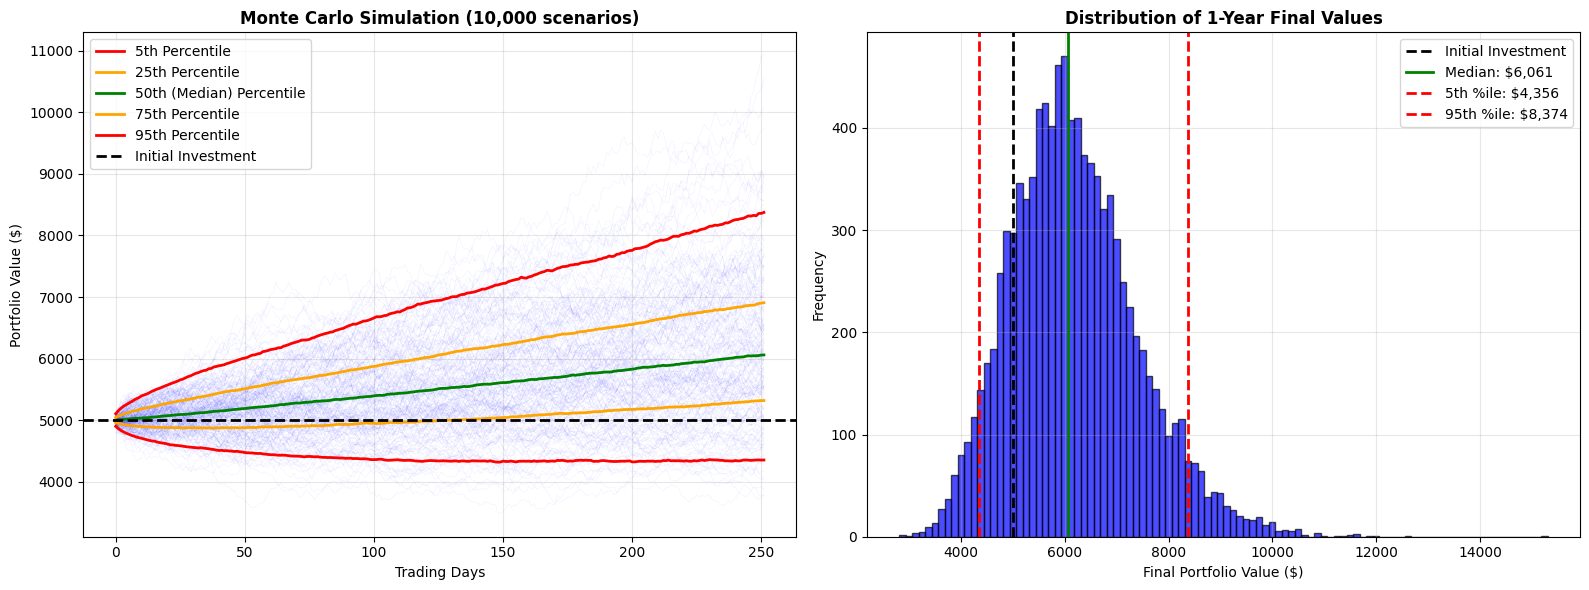

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Monte Carlo Paths
ax1 = axes[0]

# Plot a sample of paths (not all 10,000 - too cluttered)
sample_sims = np.random.choice(CONFIG['MONTE_CARLO_SIMS'], 200, replace=False)
for sim in sample_sims:
    ax1.plot(simulations[:, sim], alpha=0.05, color='blue', linewidth=0.5)

# Plot percentiles
colors = ['red', 'orange', 'green', 'orange', 'red']
labels = ['5th', '25th', '50th (Median)', '75th', '95th']
for i, (pct, color, label) in enumerate(zip(percentile_values, colors, labels)):
    ax1.plot(pct, color=color, linewidth=2, label=f'{label} Percentile')

ax1.axhline(CONFIG['PORTFOLIO_VALUE'], color='black', linestyle='--', linewidth=2, label='Initial Investment')
ax1.set_title(f'Monte Carlo Simulation ({CONFIG["MONTE_CARLO_SIMS"]:,} scenarios)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# 2. Final Value Distribution
ax2 = axes[1]
ax2.hist(final_values, bins=100, alpha=0.7, color='blue', edgecolor='black')
ax2.axvline(CONFIG['PORTFOLIO_VALUE'], color='black', linestyle='--', linewidth=2, label='Initial Investment')
ax2.axvline(median_final, color='green', linestyle='-', linewidth=2, label=f'Median: ${median_final:,.0f}')
ax2.axvline(np.percentile(final_values, 5), color='red', linestyle='--', linewidth=2, label=f'5th %ile: ${np.percentile(final_values, 5):,.0f}')
ax2.axvline(np.percentile(final_values, 95), color='red', linestyle='--', linewidth=2, label=f'95th %ile: ${np.percentile(final_values, 95):,.0f}')
ax2.set_title('Distribution of 1-Year Final Values', fontsize=12, fontweight='bold')
ax2.set_xlabel('Final Portfolio Value ($)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## ⚠️ Step 11: Risk Analysis


In [16]:
# Value at Risk (VaR) - 5% worst case
var_5 = np.percentile(final_values, CONFIG['VAR_PERCENTILE'] * 100) - CONFIG['PORTFOLIO_VALUE']

# Conditional VaR (CVaR) - average of worst 5%
cvar_5 = final_values[final_values <= np.percentile(final_values, CONFIG['VAR_PERCENTILE'] * 100)].mean() - CONFIG['PORTFOLIO_VALUE']

# Maximum expected loss
max_loss = final_values.min() - CONFIG['PORTFOLIO_VALUE']
max_loss_pct = (max_loss / CONFIG['PORTFOLIO_VALUE']) * 100

print("=" * 80)
print("⚠️  RISK ANALYSIS (1-Year Horizon)")
print("=" * 80)
print(f"\n💰 Value at Risk (VaR 95%):")
print(f"   Worst-case loss (5% probability): ${abs(var_5):,.2f} ({var_5/CONFIG['PORTFOLIO_VALUE']*100:.1f}%)")
print(f"   Interpretation: 95% confidence your loss won't exceed this")

print(f"\n💰 Conditional VaR (CVaR / Expected Shortfall):")
print(f"   Average loss in worst 5% scenarios: ${abs(cvar_5):,.2f} ({cvar_5/CONFIG['PORTFOLIO_VALUE']*100:.1f}%)")
print(f"   Interpretation: If VaR is exceeded, this is the expected loss")

print(f"\n💰 Maximum Simulated Loss:")
print(f"   Worst scenario: ${abs(max_loss):,.2f} ({max_loss_pct:.1f}%)")
print(f"   Final value: ${final_values.min():,.2f}")

print(f"\n✅ Upside Potential:")
best_case = final_values.max() - CONFIG['PORTFOLIO_VALUE']
print(f"   Best scenario gain: ${best_case:,.2f} ({best_case/CONFIG['PORTFOLIO_VALUE']*100:.1f}%)")
print(f"   Final value: ${final_values.max():,.2f}")

print(f"\n📊 Expected Returns:")
expected_gain = mean_final - CONFIG['PORTFOLIO_VALUE']
print(f"   Expected gain: ${expected_gain:,.2f} ({expected_gain/CONFIG['PORTFOLIO_VALUE']*100:.1f}%)")
print(f"   Expected final value: ${mean_final:,.2f}")

print("=" * 80)


⚠️  RISK ANALYSIS (1-Year Horizon)

💰 Value at Risk (VaR 95%):
   Worst-case loss (5% probability): $643.79 (-12.9%)
   Interpretation: 95% confidence your loss won't exceed this

💰 Conditional VaR (CVaR / Expected Shortfall):
   Average loss in worst 5% scenarios: $979.26 (-19.6%)
   Interpretation: If VaR is exceeded, this is the expected loss

💰 Maximum Simulated Loss:
   Worst scenario: $2,183.15 (-43.7%)
   Final value: $2,816.85

✅ Upside Potential:
   Best scenario gain: $10,300.14 (206.0%)
   Final value: $15,300.14

📊 Expected Returns:
   Expected gain: $1,179.73 (23.6%)
   Expected final value: $6,179.73


## 💾 Step 12: Export Results


In [17]:
# Create summary
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

summary = {
    'backtest': {
        'period_days': len(portfolio_returns),
        'total_return': float(total_return),
        'annual_return': float(annual_return),
        'annual_volatility': float(annual_volatility),
        'sharpe_ratio': float(sharpe_ratio),
        'max_drawdown': float(max_drawdown),
        'beta': float(beta),
        'alpha': float(alpha)
    },
    'monte_carlo': {
        'simulations': CONFIG['MONTE_CARLO_SIMS'],
        'forecast_days': CONFIG['FORECAST_DAYS'],
        'mean_final_value': float(mean_final),
        'median_final_value': float(median_final),
        'var_95': float(var_5),
        'cvar_95': float(cvar_5),
        'probability_loss': float(prob_loss),
        'max_loss': float(max_loss),
        'max_gain': float(best_case)
    },
    'timestamp': timestamp
}

# Save summary
import json
summary_file = data_dir / f'performance_simulation_{timestamp}.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✅ Simulation results saved: {summary_file.name}")

db.close()
print("✅ Analysis complete!")


2025-10-03 16:28:48,708 - INFO - 🔌 Database connection closed


✅ Simulation results saved: performance_simulation_20251003_1628.json
✅ Analysis complete!


## 📋 Step 13: Final Summary


In [18]:
print("=" * 80)
print("📊 PERFORMANCE SIMULATION SUMMARY")
print("=" * 80)

print(f"\n🔬 Historical Backtest ({len(portfolio_returns)} days):")
print(f"   Return: {total_return*100:+.2f}% vs S&P 500: {spy_total_return*100:+.2f}%")
print(f"   Outperformance: {(total_return-spy_total_return)*100:+.2f}%")
print(f"   Sharpe Ratio: {sharpe_ratio:.3f} vs S&P 500: {spy_sharpe:.3f}")
print(f"   Max Drawdown: {max_drawdown*100:.2f}%")

print(f"\n🎲 Monte Carlo Simulation ({CONFIG['MONTE_CARLO_SIMS']:,} scenarios):")
print(f"   Expected 1Y Value: ${mean_final:,.2f} ({(mean_final/CONFIG['PORTFOLIO_VALUE']-1)*100:+.1f}%)")
print(f"   Median 1Y Value: ${median_final:,.2f} ({(median_final/CONFIG['PORTFOLIO_VALUE']-1)*100:+.1f}%)")
print(f"   95% Confidence Range: ${np.percentile(final_values, 5):,.0f} - ${np.percentile(final_values, 95):,.0f}")
print(f"   Probability of Gain: {(1-prob_loss)*100:.1f}%")

print(f"\n⚠️  Risk Assessment:")
print(f"   VaR (95%): Maximum likely loss is ${abs(var_5):,.2f} ({abs(var_5)/CONFIG['PORTFOLIO_VALUE']*100:.1f}%)")
print(f"   CVaR (95%): Average loss in worst scenarios is ${abs(cvar_5):,.2f}")
print(f"   Worst Case: ${abs(max_loss):,.2f} loss ({abs(max_loss_pct):.1f}%)")

print(f"\n✅ Investment Recommendation:")
if sharpe_ratio > 1.0 and alpha > 0 and prob_loss < 0.3:
    print(f"   🟢 STRONG BUY: High Sharpe ({sharpe_ratio:.2f}), Positive Alpha ({alpha*100:.1f}%), Low risk")
elif sharpe_ratio > 0.5 and prob_loss < 0.4:
    print(f"   🟡 MODERATE BUY: Decent Sharpe ({sharpe_ratio:.2f}), Acceptable risk")
else:
    print(f"   🔴 CAUTION: Review risk metrics carefully")

print(f"\n📅 Next Steps:")
print(f"   1. Review risk tolerance vs VaR/CVaR")
print(f"   2. Consider position sizing adjustments")
print(f"   3. Set up monthly rebalancing")
print(f"   4. Monitor actual vs expected performance")
print(f"   5. Update predictions and re-optimize quarterly")

print("=" * 80)
print("✅ Ready to invest with confidence!")
print("=" * 80)


📊 PERFORMANCE SIMULATION SUMMARY

🔬 Historical Backtest (145 days):
   Return: +13.20% vs S&P 500: +17.08%
   Outperformance: -3.88%
   Sharpe Ratio: 0.983 vs S&P 500: 1.190
   Max Drawdown: -11.76%

🎲 Monte Carlo Simulation (10,000 scenarios):
   Expected 1Y Value: $6,179.73 (+23.6%)
   Median 1Y Value: $6,061.42 (+21.2%)
   95% Confidence Range: $4,356 - $8,374
   Probability of Gain: 83.5%

⚠️  Risk Assessment:
   VaR (95%): Maximum likely loss is $643.79 (12.9%)
   CVaR (95%): Average loss in worst scenarios is $979.26
   Worst Case: $2,183.15 loss (43.7%)

✅ Investment Recommendation:
   🟡 MODERATE BUY: Decent Sharpe (0.98), Acceptable risk

📅 Next Steps:
   1. Review risk tolerance vs VaR/CVaR
   2. Consider position sizing adjustments
   3. Set up monthly rebalancing
   4. Monitor actual vs expected performance
   5. Update predictions and re-optimize quarterly
✅ Ready to invest with confidence!
